# Algoritmo para la aproximación de datos experimentales $F(x)$ con polinomios de Chebyshev

1. Mapear los datos del intervalo $[a,b]$ al intervalo $[-1,1]$, esto porque los polinomios de Chebyshev cumplen con la propiedad de ortogonalidad en el intervalo $[-1,1]$

\begin{equation}
    x_{i}^{*}=\dfrac{2x_i-(b+a)}{(b-a)}
\end{equation}

2. Calcular los puntos ortogonales $\overline{x}_i, \overline{y}_i$:

\begin{align}
    \overline{x}_i &= \cos[\pi(2i+1)]/2N\\
    \overline{y}_i &\leftarrow spline(\overline{x}_i)
\end{align}

* Nota: El problema de los splines es que no podemos tener 2 puntos $x$'s iguales, por lo que se utiliza un proceso llamado _Stabilize_ que introduce una ligera variación aleatoria ($O(10^{-6})$) que garantiza que los splines no dejan de funcionar debido a las ordenadas idénticas.
    
3. Determinar los coeficientes del polinomio de Chebyshev $P(x)=c_0T_0+c_1T_1+...+c_mT_m$:

\begin{equation}
    \left\{\begin{matrix}
C_j = \dfrac{1}{N}\sum_{i=0}^{N-1}\overline{y}_iT_j(\overline{x}_i) & j=0\\ 
C_j = \dfrac{2}{N}\sum_{i=0}^{N-1}\overline{y}_iT_j(\overline{x}_i) & j\neq0
\end{matrix}\right.
\end{equation}

4. Determinar los coeficientes del polinomio en $[-1,1]$:

\begin{equation}
    P_1(x)=a_0+a_1x+...+a_m x^m
\end{equation}

5. Determinar los coeficientes del polinomio en $[a,b]$, que satisface $L_2$ y $L_\infty$:

\begin{equation}
    P(x)=a_0+a_1x+...+a_m x^m
\end{equation}

In [153]:
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [182]:
# FUNCIONES
def readData(path,delimiter='tab'):
    '''
    Lee un archivo csv o txt de la ruta especificada
    
    Inputs
    ----------
    path: STRING, ruta del archivo que se desea procesar
    delimiter: STRING, tipo de separador por coma (,) o tabulador (tab)
    
    Returns
    -------
    data : ARRAY, arreglo con los datos del archivo
    '''
    try:
        if delimiter == 'tab':
            data = np.genfromtxt(path,delimiter='\t')
        elif delimiter == ',':
            data = np.genfromtxt(path,delimiter=',')     
        return data
    except:
        print('El separador seleccionado no es compatible')

def getXY(data):
    '''
    De un arreglo de datos, ordena los datos en X y separa las variables X y Y
    en distintos arreglos

    Inputs
    ----------
    data: ARRAY, arreglo con los datos del archivo

    Returns
    -------
    n : INT, numero de elementos del arreglo de la variable independiente X
    x : ARRAY, vector con los datos de la variable independiente X
    y : ARRAY, vector con los datos de la variable dependiente Y
    x_min: FLOAT, valor minimo de la variable independiente X
    x_max: FLOAT, valor maximo de la variable independiente X
    '''
    # ordenar variable independiente X, de menor a mayor
    data = data[np.argsort(data[:,0])]
    # obtener cantidad de datos
    n = len(data)
    # inicializar arreglos
    x = np.zeros(n)
    y = np.zeros(n)
    # asignar valores
    for i in range(n):
        x[i] = data[i,0]
        y[i] = data[i,1]
    
    # calcular limite inferior y superior de X
    x_min = x[0]
    x_max = x[-1]
    return n,x,y, x_min, x_max

def SpCoef(n,x,y):
    '''
    Calcula el valor de la segunda derivada de la spline.

    Inputs
    ----------
    n : INT, numero de elementos del arreglo de la variable independiente X
    x : ARRAY, vector con los datos de la variable independiente X
    y : ARRAY, vector con los datos de la variable dependiente Y
    
    Parameters
    ----------
    sigma, tau : ARRAY, arreglos auxiliares de tamanio n

    Returns
    -------
    s : ARRAY, arreglo con el valor de la segunda derivada en cada punto
    '''
    # inicializar arreglos
    sigma = np.zeros(n)
    tau = np.zeros(n)
    s = np.zeros(n) # arreglo con el valor de las segundas derivadas (s[0] = s[n-1] = 0)
    
    # calcular segunda derivada [1,n-1]
    for i in range(1,n-1):
        hi_1 = x[i] - x[i-1]
        hi = x[i+1] - x[i]
        k = (hi_1/hi)*(sigma[i]+2)+2
        sigma[i+1] = -1/k
        d = (6/hi)*((y[i+1]-y[i])/hi - (y[i]-y[i-1])/hi_1)
        tau[i+1] = (d-hi_1*tau[i]/hi)/k
        
    # calcular hacia atras los valores de la segunda derivada
    for i in reversed(range(1,n-1)):
        s[i]=sigma[i+1]*s[i+1]+tau[i+1]

    return s

def Spline(n,x,y,s,x_i):
    '''
    Interpolacion de un valor alfa del spline

    Inputs
    ----------
    n : INT, numero de elementos del arreglo de la variable independiente X
    x : ARRAY, vector con los datos de la variable independiente X
    y : ARRAY, vector con los datos de la variable dependiente Y
    s : ARRAY, arreglo con el valor de la segunda derivada en cada punto
    alfa : FLOAT, valor de la variable independiente a interpolar

    Returns
    -------
    beta : FLOAT, valor de la variable dependiente
    '''
    # obtener intervalo donde se encuentra alfa
    for i in range(n):
        if x_i<=x[i]:
            break
    i=i-1
    a=x[i+1]-x_i
    b=x_i-x[i]
    hi=x[i+1]-x[i]
    y_i = a*s[i]*(a*a/hi-hi)/6+b*s[i+1]*(b*b/hi-hi)/6+(a*y[i]+b*y[i+1])/hi
    return y_i

def stabilize(x):
    n = len(x)
    for i in range(n):
        x_valor = x[i]
        # si es casi cero
        if(abs(x[i])<10e-6):
            x_valor = random.uniform(0,+10e-6)
        # ligera variacion
        else:
            x_valor = x_valor*(1+random.uniform(0,+10e-6))
        x[i] = x_valor
    return x

def mapInterval1m1p(x):
    # calculo del intervalo [a,b]
    a = x[0]
    b = x[-1]
    # inicializar x_map
    n = len(x)
    x_map = np.zeros(n)
    # calcular los valores de x_map
    for i in range(n):
        x_map[i] = (2*x[i]-(b+a))/(b-a)
    return x_map

def getXYOrthonalityPoints(n,x,y,s):
    # 1. Calcular los valores de X
    # 2. Calcular los valores de Y usando splines naturales

    ## Valores de X
    x_bar = np.zeros(n)
    y_bar = np.zeros(n)
    A = np.zeros(n)
    #for i in reversed(range(n)):
    for i in range(n):
        #x_bar[i] = math.cos(math.pi*(2*i+1))/(2*n)
        x_bar[i] = math.cos(math.pi*(2*i+1)/(2*n))
    
    x_bar = np.flip(x_bar)
    ## Valores de Y
    ### Spline
    for i in range(n):
        y_bar[i] = Spline(n,x,y,s,x_bar[i])

    return x_bar, y_bar

def getChebyshevCoef(x_bar,y_bar,D,n):
    # D+1 coeficientes
    C = np.zeros(D+1)
    for i in range(D+1):
        for j in range(n):
            C[i] = C[i]+y_bar[j]*math.cos(i*math.acos(x_bar[j]))
        if i==0:
            C[i] = C[i]/float(n)
        else:
            C[i] = C[i]*2/float(n)

    print('Coeficientes del Producto de Polinomios de Chebyshev en [-1,1]:')
    for i in range(len(C)):
        print(f'C({i}) = {C[i]}')
    return C

def getPowerCoefInterval1m1p(D,C,F):
    A=np.zeros(D+1)
    
    for U in range(1,D+1):
        for i in range(U+1):
            A[i]=0
            for j in range(i-1,U+1):
                A[i]=A[i]+C[j]*F[i][j]
                
    print('Coeficientes del Producto de Polinomios de Monomios en [-1,1]:')
    for i in range(len(A)):
        print(f'A({i}) = {A[i]}')       
    return A

def getPowerCoefIntervalab(D,G,x_min,x_max):
    U=-(x_max+x_min)/(x_max-x_min)
    V=2/(x_max-x_min)
    AB = np.zeros(D+1)
    for ix in range(1,D+1):
        i=0
        for k in range(ix+1):
            AB[k]=0
            for j in range(k,ix+1):
                AB[k]=AB[k]+G[i][j]*A[j]*math.pow(U,j-k)
        
            AB[k]=AB[k]*math.pow(V,k)
            i+=1
    print('Coeficientes del Producto de Polinomios de Monomios en [a,b]:')
    for i in range(len(AB)):
        print(f'AB({i}) = {AB[i]}') 
    return AB

def getFG(D):
    # matriz F
    F = np.zeros((D+1,D+1),dtype='int')
    G = np.zeros((D+1,D+1),dtype='int')
    
    F[0][0]=1
    F[0][1]=0
    F[1][1]=1
        
    for j in range(2,D+1):
        for i in range(1,j+1):
            # diagonal
            F[i][j]=2*F[i-1][j-1]
        for i in range(j-1):
            # triangulo superior
            F[i][j]=F[i][j]-F[i][j-2]
    
    # matriz G
    # diagonal
    for i in range(D+1):
        G[i][i]=1
    
    for i in range(D+1):
        for j in range(i+1,D+1):
            G[i][j]=G[i-1][j-1]+G[i][j-1]
            
    return F,G

def interpolate(a,b,m,AB):
    x_hat = np.linspace(a,b,m)
    y_hat = np.zeros(len(x_hat))
    for i in range(len(x_hat)):
        for j in range(len(AB)):
            y_hat[i] = y_hat[i]+AB[j]*math.pow(x_hat[i],j)
    return x_hat, y_hat

def plotInterpolation(x,y,x_hat,y_hat):
    plt.figure(figsize=(12, 8))
    plt.plot(x,y,'o',label='data',color='red')
    plt.plot(x_hat,y_hat,'o',label='Aproximación',markersize=2)
    plt.legend(loc='upper right', ncol=2)
    plt.title('Polinomio de aproximación de Chebyshev')
    plt.grid()
    plt.show()

Coeficientes del Producto de Polinomios de Chebyshev en [-1,1]:
C(0) = 2.782867200242167
C(1) = 402.4297083237841
C(2) = 114.66658593469332
C(3) = 308.16416305459666
C(4) = 39.72373203069662
C(5) = 192.00663274716726
Coeficientes del Producto de Polinomios de Monomios en [-1,1]:
A(0) = -72.15998670375453
A(1) = 437.9703828958304
A(2) = -88.4566843761863
A(3) = -2607.4760027249586
A(4) = 317.78985624557293
A(5) = 3072.106123954676
Coeficientes del Producto de Polinomios de Monomios en [a,b]:
AB(0) = -72.15998670375453
AB(1) = 87.59407657916609
AB(2) = -3.538267375047453
AB(3) = -20.859808021799672
AB(4) = 0.5084637699929168
AB(5) = 0.9830739596654966


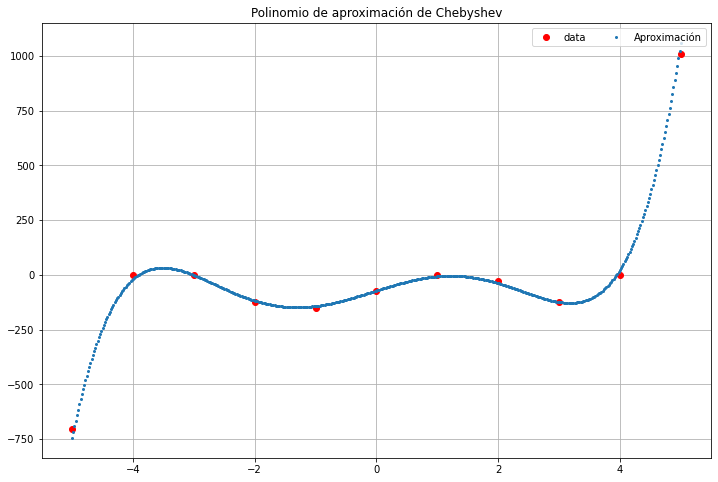

In [183]:
# grado de aproximacion del polinomio
D = 5
# leer archivo
data = readData('data_10.csv',',')
# obtener matrices F y G
F,G = getFG(D)
# obtener valores de n,x,y,x_min,x_max (en este paso tambien se ordena)
n,x,y,x_min,x_max = getXY(data)
# proceso stabilize en las abscisas
x = stabilize(x)
# mapeo en el intervalo [-1,1]
x_map = mapInterval1m1p(x)
# calcular coeficientes del spline
s = SpCoef(n,x_map,y)
# calcular los puntos ortogonales X y Y
x_bar, y_bar = getXYOrthonalityPoints(n,x_map,y,s)
# calcular los coeficientes del polinomio de Chebyshev
C = getChebyshevCoef(x_bar,y_bar,D,n)
# obtener los coeficientes del producto de potencias en monomios en [-1,1]
A = getPowerCoefInterval1m1p(D,C,F)
# obtener los coeficientes del producto de potencias en monomios en [a,b]
AB = getPowerCoefIntervalab(D,G,x_min,x_max)
# interpolar valores
x_hat, y_hat = interpolate(x_min,x_max,500,AB)
# generar grafica
plotInterpolation(x,y,x_hat,y_hat)